# additional explanation by mladen:
Some preface : in the attached article the author does a well job explaining what he felt a 2 most important points of Trend Quality indicators calculation. What is not explained there is how the "direction" (or "reversal" as the coders of tradestation, metastock, amibroker ... call it) is determined. It is a difference of 2 emas (7 and 15 ema by default) and since the difference of 2 emas is by definition macd, it turns out that the additional "spice" in these indicators is macd. It does not make these indicators a "yet another macd" indicator, since they are not that, but I felt it necessary to clarify that point too (to avoid some mis-expectations)

In [ ]:
import pandas as pd
import math
import numpy as np
import pandas_ta as ta
import matplotlib.pyplot as plt

In [ ]:
correction_factor = 2
noise_period = 250
fast_ema = 7
slow_ema = 14
trend_period = 4

In [83]:
df = pd.read_csv('av_eurusd_daily.csv')
df.set_index("timestamp", inplace=True)

In [ ]:
# Code which follows David Sepiashvili's explanation in the article.

# calculate the cumulative price change (cpc)
df['cpc'] = df['close'].diff().cumsum()
#calculate the trend.  the author didn't mention which moving average type to use but I used an EMA here
df['trend'] = df['cpc'].ewm(span=trend_period).mean()
# this is the "noise 2" calculation, again using an EMA
df['noise_ema'] = np.sqrt(((df['cpc'] - df['trend'])**2).ewm(span=noise_period).mean())
# calculate the q indicator, which is trend / noise * correction factor
df['tq_q'] = df['trend'] / df['noise_ema'] * correction_factor

# the tq_q values don't give us anything we can use right now

In [84]:
df

,open,high,low,close
timestamp,,,,
2023-11-16,1.08518,1.08955,1.08299,1.08572
2023-11-15,1.08788,1.08861,1.08313,1.08468
2023-11-14,1.06975,1.08875,1.06927,1.08787
2023-11-13,1.06826,1.07061,1.06647,1.06987
2023-11-10,1.06671,1.06930,1.06559,1.06848
...,...,...,...,...
2004-09-23,1.22560,1.23380,1.22510,1.22680
2004-09-22,1.23360,1.23380,1.22230,1.22630
2004-09-21,1.21650,1.23450,1.21630,1.23250


In [85]:
alpha1 = 2.0 / (1.0 + fast_ema)
alpha2 = 2.0 / (1.0 + slow_ema)
df['fast_ema'] = df['close'].ewm(alpha=alpha1, adjust=False).mean()
df['slow_ema'] = df['close'].ewm(alpha=alpha2, adjust=False).mean()
df['macd'] = df['fast_ema'] - df['slow_ema']
df['sign'] = np.sign(df['macd'])
df['change'] = (df['close'] - df['close'].shift(1)).abs()

In [86]:
df[['cpc', 'trend']] = 0

In [87]:
# truth statement
# if (work[r][_sign] != work[r-1][_sign])
# original mql4 evaluates if the sign is different from the previous sign
# I am choosing to evaluate if the sign is the same as the previous sign

mask = df['sign'] == df['sign'].shift(1)

In [88]:
# modify cpc
df.loc[mask, 'cpc'] = df['sign'] * df['change'] + df['cpc'].shift(1)
df['cpc'] = df['cpc'].fillna(0)

C:\Users\k0240\AppData\Local\Temp\ipykernel_10464\2480377133.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.00139 -0.00177 -0.00419 ... -0.0062  -0.016   -0.0008 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[mask, 'cpc'] = df['sign'] * df['change'] + df['cpc'].shift(1)


In [89]:
# modify trend
df.loc[mask, 'trend'] = df['cpc'] * (1.0 / trend_period) + df['trend'].shift(1) * (1.0 - (1.0 / trend_period))
df['trend'] = df['trend'].fillna(0)

C:\Users\k0240\AppData\Local\Temp\ipykernel_10464\3226708072.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.0003475 -0.0004425 -0.0010475 ... -0.00155   -0.004     -0.0002   ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[mask, 'trend'] = df['cpc'] * (1.0 / trend_period) + df['trend'].shift(1) * (1.0 - (1.0 / trend_period))


In [90]:
# add dt which is cpc - trend squared (I don't really understand the purpose of this)
df['dt'] = df['cpc'] - df['trend'] ** 2

In [91]:
# add avgDt which is the rolling mean of dt
# double avgDt = 0; for (k=0; k<NoisePeriod; k++) avgDt += work[r-k][_dt]; avgDt /= NoisePeriod;
df['avgDt'] = df['dt'].rolling(window=noise_period).mean()

In [92]:
# double noise = CorrectionFactor*MathSqrt(avgDt);
df['noise'] = correction_factor * (df['avgDt'] ** .5)

In [93]:
# final q calculation
# currently unusable

mask = df['noise'] != 0
df['q'] = 0
df.loc[mask, 'q'] = df['trend'] / df['noise']

C:\Users\k0240\AppData\Local\Temp\ipykernel_10464\3427380491.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[        nan         nan         nan ... -0.03248185 -0.09182183
 -0.00461057]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[mask, 'q'] = df['trend'] / df['noise']


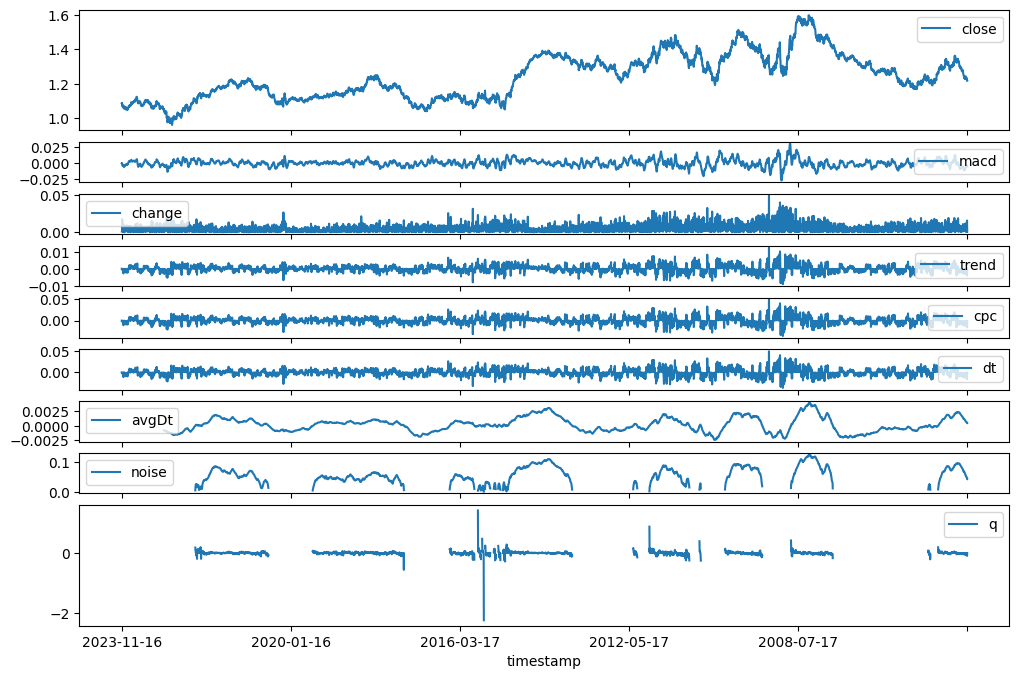

In [ ]:
# plot values

fig, axs = plt.subplots(9, sharex=True, gridspec_kw={'height_ratios': [3, 1, 1, 1, 1, 1, 1, 1, 3]}, figsize=(12,8))

df[['close']].plot(ax=axs[0])

df[['macd']].plot(ax=axs[1])

df[['change']].plot(ax=axs[2])

df[['trend']].plot(ax=axs[3])

df[['cpc']].plot(ax=axs[4])

df[['dt']].plot(ax=axs[5])

df[['avgDt']].plot(ax=axs[6])

df[['noise']].plot(ax=axs[7])

df[['q']].plot(ax=axs[8])

plt.show()

In [ ]:
#unused lines

#df['cpc'] = df['close'].diff().cumsum()
#df['change'] = abs(df['cpc'])
#df['price_change'] = df['close'].diff()
#df['cpc'] = df['price_change']
#df.loc[df['macd_sign'] == df['macd_sign'].shift(), 'cpc'] = df['price_change'] + df['cpc'].shift()
#df['noise'] = np.sqrt(df['dt'].ewm(span=noise_period).mean())
#df['trend'] = df['cpc'].ewm(span=trend_period).mean()
#df['noise'] = np.sqrt(((df['cpc'] - df['trend'])**2).ewm(span=noise_period).mean())
# df.loc[df['sign'] != df['sign'].shift(1), ['cpc', 'trend']] = 0
# mask = df['sign'] == df['sign'].shift(1)
# df.loc[mask, 'cpc'] = df['sign'] * df['change'] + df['cpc'].shift(1)
# df.loc[mask, 'trend'] = df['cpc'] * (1.0 / trend_period) + df['trend'].shift(1) * (1.0 - (1.0 / trend_period))
# df['dt'] = (df['cpc'] - df['trend']) ** 2
# df['avgDt'] = df['dt'].rolling(window=noise_period).mean()
# df['noise'] = correction_factor * df['avgDt'].apply(np.sqrt)
# df['trendQ'] = df['trend'] / df['noise'].replace(0, np.nan)
# df['trendQu'] = np.nan
# df['trendQd'] = np.nan
# df.loc[df['trendQ'] > 0, 'trendQu'] = df['trendQ']
# df.loc[df['trendQ'] < 0, 'trendQd'] = df['trendQ']